## Parrot eval

In [1]:
! pip install git+https://github.com/PrithivirajDamodaran/Parrot.git

  Cloning https://github.com/PrithivirajDamodaran/Parrot.git to /tmp/pip-req-build-xena_1zd
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Parrot.git /tmp/pip-req-build-xena_1zd
  Resolved https://github.com/PrithivirajDamodaran/Parrot.git to commit 720a87a1ee557d8ed8d9a021adbdd1dd5616c5f9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
# Import libraries
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")
from parrot.filters import Adequacy, Fluency, Diversity
import numpy as np


In [3]:
# For reproducibility
def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)

In [4]:
#Init models (make sure you init ONLY once if you integrate this to your code)
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)
diversity = Diversity()
adequacy = Adequacy()
fluency = Fluency()

In [5]:
## list of object -> array; dict is dict
per_list = np.load('parrot_per.npy', allow_pickle=True)
#orig = np.load('Orig_ques.npy', allow_pickle=True)

In [9]:
phrases = ['What is the most delicious papayes?']
for phrase in phrases:
  print("-"*100)
  print("Input_phrase: ", phrase)
  print("-"*100)
  para_phrases = parrot.augment(input_phrase=phrase)
  for para_phrase in para_phrases:
   print(para_phrase)

----------------------------------------------------------------------------------------------------
Input_phrase:  What is the most delicious papayes?
----------------------------------------------------------------------------------------------------
('tell me the best papaya you have ever tasted?', 37)
("what's your favorite papaya dish?", 34)
('which is the best papaya?', 28)
('tell me the most delicious papaya?', 19)
('list the most delicious papayes?', 17)
('list some of the most delicious papayes?', 16)


In [16]:
a_result_list = []
b_result_list = []
c_result_list = []
for item_dict in per_list:
  resulta = dict()
  resultb = dict()
  resultc = dict()
  for input_p, p in item_dict.items():
    score_a = adequacy.score(input_p, p, 0.01)
    score_b = fluency.score(p, 0.01)
    score_c = diversity.rank(input_p, p)
    resulta[input_p] = list(score_a.values())
    resultb[input_p] = list(score_b.values())
    resultc[input_p] = list(score_c.values())

  a_result_list.append(resulta)
  b_result_list.append(resultb)
  c_result_list.append(resultc)

KeyboardInterrupt: ignored

In [17]:
len(a_result_list)

3

In [18]:
np.save('ade.npy', a_result_list)
np.save('flu.npy', b_result_list)
np.save('div.npy', c_result_list)

## Dataset exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [119]:
orig = np.load('orig_dict.npy', allow_pickle=True)
per = np.load('per_dict.npy', allow_pickle=True)
## initialize Dataframe
test_type = ['antonym', 'ontological', 'phrasal', 'symmetry', 'negation']

def create_ques_df():
    df = pd.DataFrame(columns=['sent', 'test_type', 'perturbed', 'img_id'])
    for test, item in zip(test_type, orig):
        for ques in item.values():
            sent = ques['sent']
            is_per = ques['perturbed']
            img = ques['img_id']
            df.loc[len(df.index)] = [sent, test, is_per, img]

    for test, item in zip(test_type, per):
        for ques in item.values():
            sent = ques['sent']
            is_per = ques['perturbed']
            img = ques['img_id']
            df.loc[len(df.index)] = [sent, test, is_per, img]

    df.to_json('carets1.json')

In [22]:
list(orig[0].values())[0]

{'img_id': '1592413',
 'label': {'yes': 1.0},
 'question_id': 0,
 'sent': 'Is the jacket to the right of the black remote control black?',
 'question_type': 'attribute_verification_rel1',
 'assignment': {'2rel1': 'to the right of',
  'attrs1': ['black'],
  'attrs2': ['black'],
  'obj1': 'jacket',
  'obj1_id': '4442427',
  'obj2': 'remote control',
  'obj2_id': '4442449'},
 'paired_question_id': 2383,
 'image_path': '/cluster/scratch/minqin/hf_vqa/CARETS/data/images/1592413.jpg',
 'perturbed': False}

In [5]:
## read from repo, under stats / run the function create_ques_df() to get data
df = pd.read_json('carets1.json',orient='columns' , encoding = 'utf-8-sig')

In [6]:
df

,sent,test_type,perturbed,img_id
0,Is the jacket to the right of the black remote...,antonym,False,1592413
1,Does it seem that the gate behind the standing...,antonym,False,2388821
2,Does it look like the pants that are to the le...,antonym,False,2393164
3,Does it look like the seat that is on the red ...,antonym,False,2406999
4,Does it look like the eye that is of the small...,antonym,False,2631
...,...,...,...,...
125745,Do you see a blue concrete walkway that is in ...,negation,False,2372121
125746,Is there a young woman holding the helmet in t...,negation,False,2406331
125747,Does it look like there is a bare tree on top ...,negation,False,2356847
125748,Is there a blue train on top of the rusty trai...,negation,False,2394753


### Text len

<Axes: >

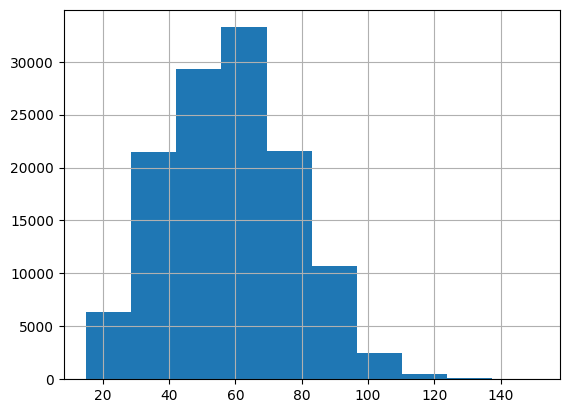

In [9]:
## character size
df1['sent'].str.len().hist()

<Axes: >

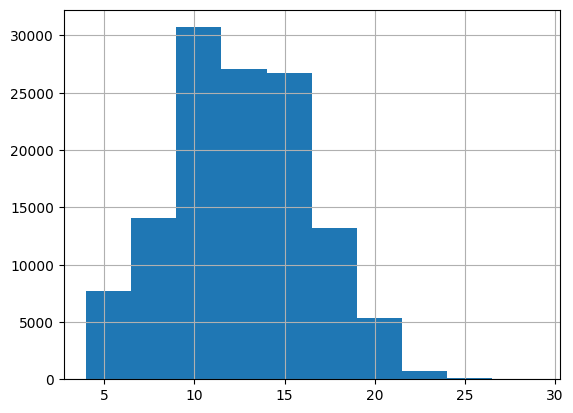

In [11]:
df1['sent'].str.split().map(lambda x: len(x)).hist()

### Word pie chart

In [7]:
word_df = df.copy()
word_df['first'] = word_df['sent'].str.split().map(lambda x: x[0])
word_df['second'] = word_df['sent'].str.split().map(lambda x: x[1])
word_df['third'] = word_df['sent'].str.split().map(lambda x: x[2])
word_df['fourth'] = word_df['sent'].str.split().map(lambda x: x[3])

In [21]:
def my_autopct(pct):
  return ('%%.1f'%pct) if pct>10 else ''

In [39]:
def my_label_list(values, labels):
  value_sum = sum(values)
  pcts = [value/value_sum for value in values]
  res_labels = []
  for pct, label in zip(pcts, labels):
    if pct > 0.02:
      res_labels.append(label)
    else:
      res_labels.append('')

  return res_labels

In [47]:
def build_pie_chart(test_type):

  word_df1 = word_df[word_df["test_type"]==test_type]
  #df1_per = word_df1[word_df1["perturbed"]==True]
  #df1_ori = word_df1[word_df1["perturbed"]==False]

  mult_df1_ind = pd.MultiIndex.from_frame(word_df1[['first', 'second', 'third', 'fourth']])
  mult_df1 = pd.Series(np.ones(len(word_df1['sent']), dtype=int), index=mult_df1_ind)

  size = 0.4
  inner1 = mult_df1.groupby(level=0).sum()
  inner1_v = inner1.values.tolist()
  inner1_k = inner1.index.tolist()
  label1 = my_label_list(inner1_v, inner1_k)

  inner2 = mult_df1.groupby(level=[0,1]).sum()
  inner2_v = inner2.values.tolist()
  inner2_k = inner2.index.get_level_values(1).tolist()
  label2 = my_label_list(inner2_v, inner2_k)

  inner3 = mult_df1.groupby(level=[0,1,2]).sum()
  inner3_v = inner3.values.tolist()
  inner3_k = inner3.index.get_level_values(2).tolist()
  label3 = my_label_list(inner3_v, inner3_k)

  inner4 = mult_df1.groupby(level=[0,1,2,3]).sum()
  inner4_v = inner4.values.tolist()
  inner4_k = inner4.index.get_level_values(3).tolist()
  label4 = my_label_list(inner4_v, inner4_k)


  plt.pie(inner1_v, radius=1.4-size*2, labels=label1, labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

  plt.pie(inner2_v, radius=1.4-size, labels=label2, labeldistance=0.7, wedgeprops=dict(width=size, edgecolor='w'))

  plt.pie(inner3_v, radius=1.4, labels=label3, labeldistance=0.8, wedgeprops=dict(width=size, edgecolor='w'))

  plt.pie(inner4_v, radius=1.4+size, labels=label4, labeldistance=0.85, wedgeprops=dict(width=size, edgecolor='w'))



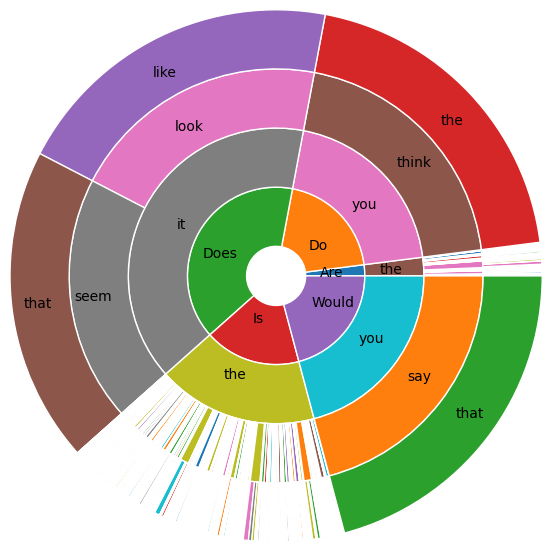

In [48]:
build_pie_chart('antonym')

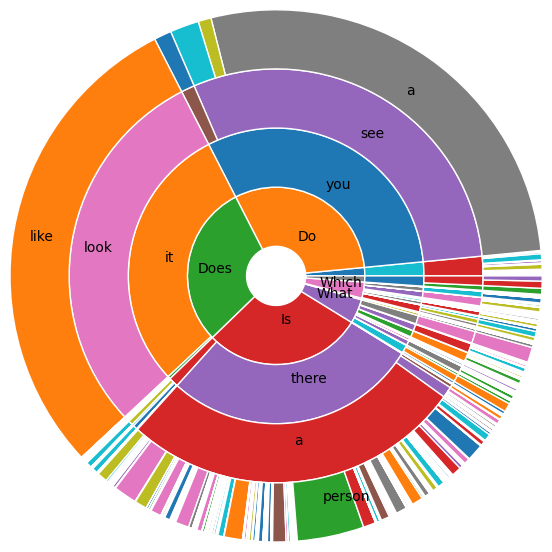

In [49]:
build_pie_chart('ontological')

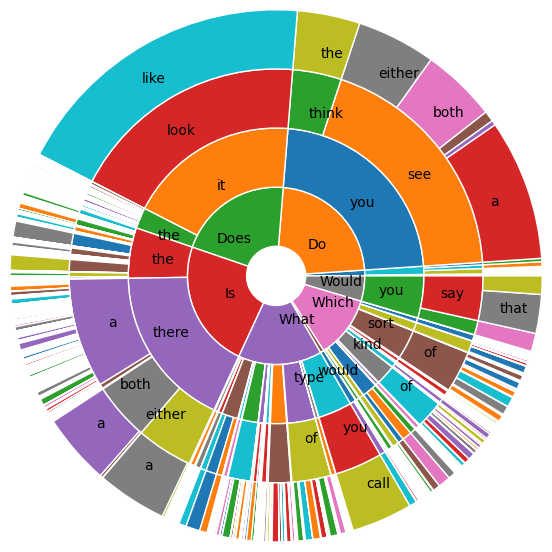

In [50]:
build_pie_chart('phrasal')

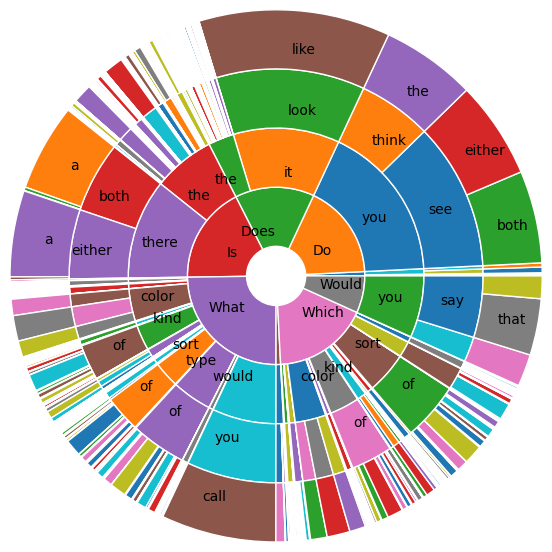

In [51]:
build_pie_chart('symmetry')

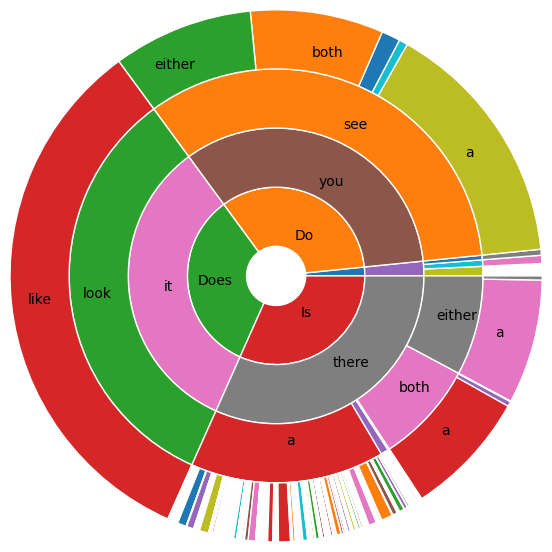

In [52]:
build_pie_chart('negation')

In [159]:
idx = pd.IndexSlice
test.loc[('Are', 'the')]

<ipython-input-159-21aa1fbd1a45>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  test.loc[('Are', 'the')]


third
numbers    1
shorts     1
blinds     1
trees      1
pants      1
          ..
plants     1
trees      1
pants      1
walls      1
shorts     1
Length: 202, dtype: int64